In [1]:


import matplotlib
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

# import sklearn
# from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder, PolynomialFeatures, MaxAbsScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, confusion_matrix
import numpy.random as r
import disarray

import pickle 
from mpl_toolkits import mplot3d
import seaborn


/var/folders/80/xm3s4xmn36zf26_wljf16p_m0000gn/T/ipykernel_40074/1160963198.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Preprocessing the data!

In [2]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)
dnnd = 7
#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Modulation_Original'] = rf_data['Modulation']
rf_data['Modulation'] = label_encoder.fit_transform(rf_data['Modulation']) + 1  # Add 1 to avoid 0 indexing
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
rf_data['Device Type'] = label_encoder.fit_transform(rf_data['Device Type']) + 1
# print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Device Status','Modulation','Timestamp','Location','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original','Weather Condition','Antenna Type', 'Battery Level' ])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X)
# print(X_train)

# Supervised Analysis I: Logistic Regression

In [3]:
# trainingError, validationError, variance, recall = [[1, 2, 3, 4, 5],[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]], [], [], []
# for each in overfitting(3):
#     for each in regularization(5):
#         train the Model
#         trainingError[overfit][regular] = training error of this model



Process the data so that we can perform logistic regression:

In [4]:
ones = np.ones((X_train.shape[0],1))
ones2 = np.ones((X_test.shape[0],1))
X_train = np.hstack((ones,X_train))
X_test = np.hstack((ones2,X_test))
# y_train = np.array(y_train).reshape(-1, 1)
# y_test = np.array(y_test).reshape(-1, 1)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# class_names=['1', '2', '3', '4', '5', '6'] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')

# plt.Text(0.5,257.44,'Predicted label')

In [6]:
XTrainPolynomialDegrees = {}
XTestPolynomialDegrees = {}
polyOrders = [1, 2, 3]
# polyOrders = [1]
maxScaler = MaxAbsScaler()
normalScaler = Normalizer()
for i in polyOrders:
    poly = PolynomialFeatures(i)
    XTrainPolynomialDegrees[i] = normalScaler.fit_transform(scaler.fit_transform(poly.fit_transform(X_train)))
    XTestPolynomialDegrees[i] = normalScaler.fit_transform(scaler.fit_transform(poly.fit_transform(X_test)))

In [7]:
# iters = np.array(range(0,num_iters,10))
# # iters = np.array(range(num_iters))
# plt.plot(iters,log_likelihood_values,'.-',color='green')
# plt.xlabel('Number of iterations')
# plt.ylabel('Log-Likelihood')
# plt.title("Log-Likelihood vs Number of Iterations.")
# plt.grid()
# plt.show(block=False)

In [8]:

CSValues = [1, 2, 5, 10]
# CSValues = [1, 2]
dict = {}
for j in CSValues:
    dict[f'CS = {j}']={}
    for i in polyOrders:
        print(f"Now performing CS = {j}, Polynomial order of data = {i}")
        dict[f'CS = {j}'][f'Polynomial order of data = {i}']={}
        logreg = LogisticRegressionCV(Cs =j,random_state=32, multi_class='multinomial', penalty = 'elasticnet',max_iter=100, solver = 'saga', l1_ratios=[.25], cv=2)
        logreg.fit(XTrainPolynomialDegrees[i], y_train)
        y_pred = logreg.predict(XTestPolynomialDegrees[i])
        training_error = 1-logreg.score(XTrainPolynomialDegrees[i],y_train)
        validation_error = 1-logreg.score(XTestPolynomialDegrees[i],y_test)
        dict[f'CS = {j}'][f'Polynomial order of data = {i}'] = [training_error, validation_error, y_pred, logreg.coefs_paths_, logreg.intercept_]


# CsMin = 1
# CsMax = 1
# for j in range(CsMin, CsMax+1):
#     dict[j]={}
#     for i in range(len(XTrainPolynomialDegrees)):
#         logreg = LogisticRegressionCV(Cs =j,random_state=32, multi_class='multinomial', penalty = 'elasticnet',max_iter=1000, solver = 'saga', l1_ratios=[0], cv=0)
#         # logreg = LogisticRegression(random_state=32, multi_class='multinomial', penalty = 'elasticnet',max_iter=1000, solver = 'saga', l1_ratios=[0], cv=0)
#         logreg.fit(XTrainPolynomialDegrees[i], y_train)
#         y_pred_regularized = logreg.predict(XTestPolynomialDegrees[i])
#         # training_error = 1-logreg.score(XTrainPolynomialDegrees[i],y_train)
#         # validation_error = 1-logreg.score(XTestPolynomialDegrees[i],y_test)
#         # cnf_matrix = confusion_matrix(y_test, y_pred)
#         # dict[j][i] = [training_error, validation_error, cnf_matrix, y_pred]
#         dict[j][i]

        
        

Now performing CS = 1, Polynomial order of data = 1
Now performing CS = 1, Polynomial order of data = 2
Now performing CS = 1, Polynomial order of data = 3
Now performing CS = 2, Polynomial order of data = 1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now performing CS = 2, Polynomial order of data = 2
Now performing CS = 2, Polynomial order of data = 3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now performing CS = 5, Polynomial order of data = 1


KeyboardInterrupt: 

In [ ]:
# for j in range(CsMin, CsMax+1):
#     for i in range(len(XTrainPolynomialDegrees)):
#         df = pd.DataFrame(dict[j][i][2], index= ['8PSK','AM','BPSK','FM','QAM','QPSK'], columns=['8PSK','AM','BPSK','FM','QAM','QPSK'])
#         dict[j][i].append(df.da.export_metrics())
        
#         # TP = np.diag(dict[j][i][2])
#         # # print(TP)
#         # FP = np.sum(dict[j][i][2],axis=0) - TP
#         # # print(FP)
#         # FN = np.sum(dict[j][i][2], axis=1) - TP
#         # # print(FN)
#         # num_classes = 6
#         # TN = []
#         # for k in range(num_classes):
#         #     temp = np.delete(dict[j][i][2], k, 0)    # delete ith row
#         #     temp = np.delete(temp, k, 1)  # delete ith column
#         #     TN.append(sum(sum(temp)))
#         # TN = sum(TN)
#         # TP = TP.sum()
#         # FP = FP.sum()
#         # FN = FN.sum()
#         # # print(TN)
#         # stuff = [TP,FP,FN,TN,(TP/(TP+FP)),(TP/(TP+FN))]
#         # # print(stuff)
#         # # print(dict[j][i])
#         # [dict[j][i].append(elem) for elem in stuff]
#         # # print(dict[j][i])


# print(r2_score(y_test, y_pred))

# print(dict[1][0][3])

# # for j in range(CsMin, CsMax+1):
# #     for i in range(len(XTrainPolynomialDegrees)):
# #         print(f'For a degree {i+1} transformation of the data, with Cs = {j}, the precision is {dict[j][i][-2]} and the recall is {dict[j][i][-1]}, TP: {dict[j][i][-6]}, FP: {dict[j][i][-5]}, FN: {dict[j][i][-4]}, TN: {dict[j][i][-3]}')


# print('')
# for j in range(CsMin, CsMax+1):
#     for i in range(len(XTrainPolynomialDegrees)):
#         print(f'For a degree {i+1} transformation of the data, with Cs = {j}, the training error is {dict[j][i][0]} and the validation error is {dict[j][i][1]}')
# print('')
# for j in range(CsMin, CsMax+1):
#     for i in range(len(XTrainPolynomialDegrees)):
#         print(f'For a degree {i+1} transformation of the data, with Cs = {j}, the training accuracy is {1-dict[j][i][0]} and the validation accuracy is {1-dict[j][i][1]}')

In [ ]:
# cnf_matrix = confusion_matrix(y_test, y_pred)

  
# Create a variable 

  
# Open a file and use dump() 
with open('LogisticRegResults4CS3DNormal&StandardScalers.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(dict, file)

In [11]:
with open('LogisticRegResults4CS3DStandardScalerColumnY.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    dict = pickle.load(file) 
  


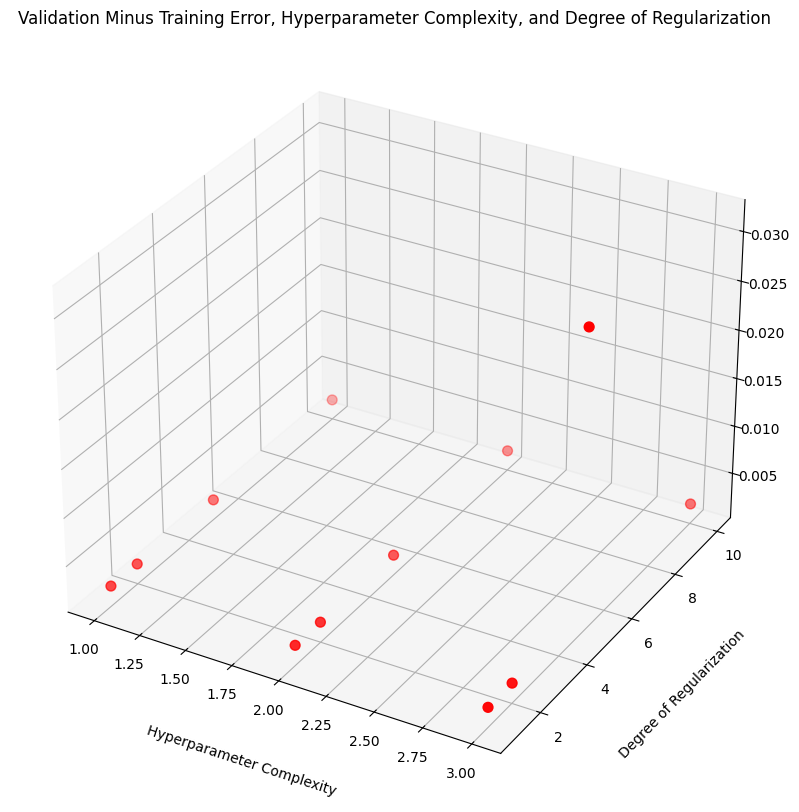

In [16]:
%matplotlib inline
x = polyOrders
y = CSValues
X, Y = np.meshgrid(x,y)

Z = np.zeros(X.shape)
for j in range(Z.shape[0]):
    for i in range(Z.shape[1]):
        Z[j, i]= dict[f'CS = {Y[j, i]}'][f'Polynomial order of data = {X[j, i]}'][1] - dict[f'CS = {Y[j, i]}'][f'Polynomial order of data = {X[j, i]}'][0]


fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X, Y, Z, c = 'r', s = 50)

ax.set_title('Validation Minus Training Error, Hyperparameter Complexity, and Degree of Regularization')

# Set axes label
ax.set_xlabel('Hyperparameter Complexity', labelpad=20)
ax.set_ylabel('Degree of Regularization', labelpad=20)
ax.set_zlabel('Validation Minus Training Error', labelpad=20)
plt.show()

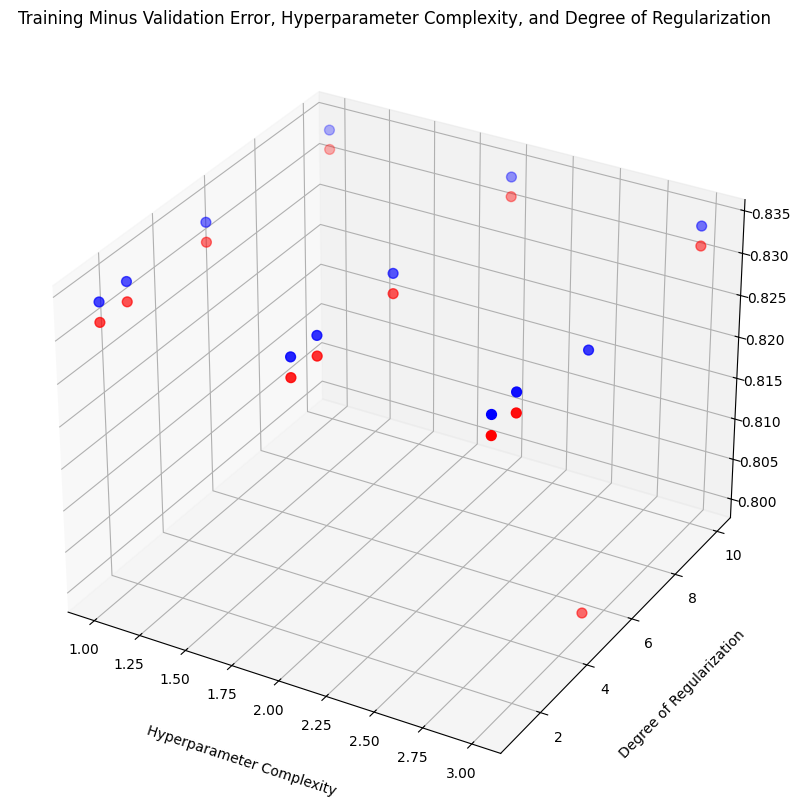

In [15]:
x = polyOrders
y = CSValues
X, Y = np.meshgrid(x,y)

Z_training = np.zeros(X.shape)
for j in range(Z.shape[0]):
    for i in range(Z.shape[1]):
        Z_training[j, i]= dict[f'CS = {Y[j, i]}'][f'Polynomial order of data = {X[j, i]}'][0]

Z_validation = np.zeros(X.shape)
for j in range(Z.shape[0]):
    for i in range(Z.shape[1]):
        Z_validation[j, i]= dict[f'CS = {Y[j, i]}'][f'Polynomial order of data = {X[j, i]}'][1]

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X, Y, Z_training, c = 'r', s = 50)
ax.scatter(X, Y, Z_validation, c = 'b', s = 50)

ax.set_title('Training Minus Validation Error, Hyperparameter Complexity, and Degree of Regularization')

# Set axes label
ax.set_xlabel('Hyperparameter Complexity', labelpad=20)
ax.set_ylabel('Degree of Regularization', labelpad=20)
ax.set_zlabel('Training Minus Validation Error', labelpad=20)
plt.show()